In [125]:
import tensorflow as tf
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np

In [154]:
#DATA COLLECTION #2017-05-18 #2022-05-14
start = pd.to_datetime(['2017-06-08']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2022-06-07']).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + 'AMZN' + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
df = pd.read_csv(url)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,112.994316,114.253005,111.566079,112.920975,112.920975,8.680541e+07
std,41.422271,41.927355,40.858735,41.354838,41.354838,4.158991e+07
min,47.000000,47.431499,46.349998,46.930000,46.930000,1.762600e+07
25%,82.908876,83.883123,81.673125,82.984625,82.984625,5.848150e+07
50%,95.969250,96.814751,94.992752,95.658749,95.658749,7.498000e+07
75%,158.346878,159.930752,156.224998,158.093746,158.093746,1.028830e+08
max,187.199997,188.654007,184.839493,186.570496,186.570496,3.313000e+08


In [156]:
dfc=df.reset_index()['Close']
#When we reset the index, the old index is added as a column,
#and a new sequential index is used
dfc.shape

(1258,)

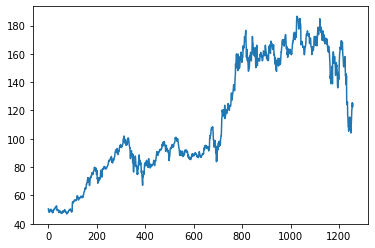

In [157]:
plt.plot(dfc)

In [158]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
dfc=scaler.fit_transform(np.array(dfc).reshape(-1,1)) #Fit to data, then transform it. 
#Reshaping to (,1) is needed for fit_transform function

In [159]:
dfc

array([[0.02566233],
       [0.01421866],
       [0.00942061],
       ...,
       [0.56273792],
       [0.54010119],
       [0.55757465]])

In [160]:
#In case of time series data we should always do train-test split in sequential manner because here todays data is dependent on yesterdays data
training_size=int(len(dfc)*0.65)
test_size=len(dfc)-training_size
train_data,test_data=dfc[0:training_size,:],dfc[training_size:len(dfc),:1]
training_size,test_size

(817, 441)

In [161]:
#convert an array of values into a dataset matrix
def datasetmatrix(dataset,time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]  ##i=0 , 0,1,2....199 200
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)    

In [162]:
#reshape into X=t,t+1,t+2..t+n , Y=t+n+1
time_step=200
X_train,y_train=datasetmatrix(train_data,time_step)
X_test,y_test=datasetmatrix(test_data,time_step)

In [163]:
X_train.shape, y_train.shape,X_test.shape, y_test.shape

((616, 200), (616,), (240, 200), (240,))

In [164]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [165]:
##LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [166]:
model=Sequential()
model.add(LSTM(64, input_shape=(200, 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, input_shape=(200, 1), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32,kernel_initializer="uniform",activation='relu'))  
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
model.compile(loss='mean_absolute_error',optimizer='adam')
#FB,UNH,GOOGL

In [167]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 200, 64)           16896     
                                                                 
 dropout_39 (Dropout)        (None, 200, 64)           0         
                                                                 
 lstm_40 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_40 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 52,033
Trainable params: 52,033
Non-tra

In [168]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
20/20 [==============================] - 13s 421ms/step - loss: 0.2623 - val_loss: 0.4008
Epoch 2/100
20/20 [==============================] - 3s 171ms/step - loss: 0.1025 - val_loss: 0.4634
Epoch 3/100
20/20 [==============================] - 3s 166ms/step - loss: 0.0948 - val_loss: 0.4695
Epoch 4/100
20/20 [==============================] - 3s 166ms/step - loss: 0.0893 - val_loss: 0.3550
Epoch 5/100
20/20 [==============================] - 3s 163ms/step - loss: 0.1081 - val_loss: 0.3806
Epoch 6/100
20/20 [==============================] - 3s 165ms/step - loss: 0.0925 - val_loss: 0.3965
Epoch 7/100
20/20 [==============================] - 3s 169ms/step - loss: 0.0817 - val_loss: 0.3179
Epoch 8/100
20/20 [==============================] - 3s 165ms/step - loss: 0.0518 - val_loss: 0.0825
Epoch 9/100
20/20 [==============================] - 3s 167ms/step - loss: 0.0393 - val_loss: 0.0601
Epoch 10/100
20/20 [==============================] - 3s 164ms/step - loss: 0.0353 - val_l

In [171]:
model.save(r"AMZN.h5")

In [169]:
trp=model.predict(X_train)
tep=model.predict(X_test)
train_predict=np.array(trp).reshape(-1,)
test_predict=np.array(tep).reshape(-1,)

In [170]:
#Performance Metrics
#Training Data
bias=(sum(abs(y_train-train_predict)/y_train)/len(y_train))*100
accuracy=(1-(sum(abs(y_train-train_predict)/y_train)/len(y_train)))*100
print("Train_bias",round(bias,2)),print("Train_acc",round(accuracy,2))
#Testing Data
bias=(sum(abs(y_test-test_predict)/y_test)/len(y_test))*100
accuracy=(1-(sum(abs(y_test-test_predict)/y_test)/len(y_test)))*100
print("Test_bias",round(bias,2)),print("Test_acc",round(accuracy,2))

Train_bias 4.05
Train_acc 95.95
Test_bias 3.45
Test_acc 96.55


(None, None)

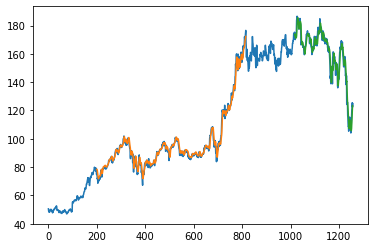

In [172]:
# Plotting
# shift train predictions for plotting
train_predict=trp
test_predict=tep
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
back=200
trainpredictplt=np.empty_like(dfc)
trainpredictplt[:,:]=np.nan
trainpredictplt[back:len(train_predict)+back,:]=train_predict
# shift test predictions for plotting
testpredictplt=np.empty_like(dfc)
testpredictplt[:,:]=np.nan
testpredictplt[len(train_predict)+(back*2)+1:len(dfc)-1,:]=test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dfc))
plt.plot(trainpredictplt)
plt.plot(testpredictplt)
plt.show()

In [173]:
len(test_data)

441

In [174]:
x_input=test_data[241:].reshape(1,-1)
x_input.shape

(1, 200)

In [175]:
temp_list=list(x_input)
temp_list=temp_list[0].tolist()

In [176]:
temp_list

[0.8097042135971789,
 0.833307717554942,
 0.847597970434021,
 0.8452347519590594,
 0.8512573816695698,
 0.8632990389836485,
 0.8890580423031441,
 0.9066818625450886,
 0.909621496904451,
 0.9039355317099419,
 0.9092813305389579,
 0.9204671759401372,
 0.9262713733127962,
 0.9114690698320064,
 0.9060946331786163,
 0.9018050537431493,
 0.8992377111006539,
 0.908472174146388,
 0.9129300357111308,
 0.9037207014790324,
 0.8654831690085089,
 0.8611506435783499,
 0.8741912661209682,
 0.8870636136955573,
 0.8904723526619386,
 0.8834113064164425,
 0.8512430663380056,
 0.8459293928603636,
 0.8401717435893384,
 0.8395343568530437,
 0.8060627198001361,
 0.8172414612448814,
 0.8319255325475213,
 0.8463984974673825,
 0.841453613857115,
 0.8263004307862097,
 0.8266692278148312,
 0.839899659193419,
 0.8454782056918505,
 0.8845643458613898,
 0.8980704709040851,
 0.8971430751721193,
 0.8867270565982522,
 0.893870385564944,
 0.8582574499019254,
 0.8528220495578877,
 0.872766142280102,
 0.8786455184175227,


In [177]:
# Next 50 days prediction
from numpy import array
lst_output=[]
n_steps=200
i=0
while(i<50):
    
    if(len(temp_list)>200):
        x_input=np.array(temp_list[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input=x_input.reshape((1,n_steps,1))
        yhat=model.predict(x_input,verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_list.extend(yhat[0].tolist())
        temp_list=temp_list[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input=x_input.reshape((1,n_steps,1))
        yhat=model.predict(x_input,verbose=0)
        print(yhat[0])
        temp_list.extend(yhat[0].tolist())
        print(len(temp_list))
        lst_output.extend(yhat.tolist())
        i=i+1 
        
        
print(lst_output)              

[0.55711436]
201
1 day input [0.83330772 0.84759797 0.84523475 0.85125738 0.86329904 0.88905804
 0.90668186 0.9096215  0.90393553 0.90928133 0.92046718 0.92627137
 0.91146907 0.90609463 0.90180505 0.89923771 0.90847217 0.91293004
 0.9037207  0.86548317 0.86115064 0.87419127 0.88706361 0.89047235
 0.88341131 0.85124307 0.84592939 0.84017174 0.83953436 0.80606272
 0.81724146 0.83192553 0.8463985  0.84145361 0.82630043 0.82666923
 0.83989966 0.84547821 0.88456435 0.89807047 0.89714308 0.88672706
 0.89387039 0.85825745 0.85282205 0.87276614 0.87864552 0.8980096
 0.87146286 0.85201289 0.85009364 0.87560558 0.90890544 0.92394038
 0.91319502 0.94443587 0.91071356 0.90729411 0.92614614 0.93349709
 0.93171399 0.93468586 0.98734248 0.98036393 0.94312537 0.94580013
 0.94593257 0.91877357 0.93918677 0.91967233 0.89698912 0.89471177
 0.87767879 0.89113476 0.92548013 0.92543359 0.91120419 0.89717532
 0.87823739 0.87482865 0.90507414 0.87324956 0.88145993 0.86041656
 0.88432088 0.88876083 0.88898637 

In [178]:
days_200=np.arange(1,201)
days_pred=np.arange(201,251)

In [179]:
len(dfc)

1258

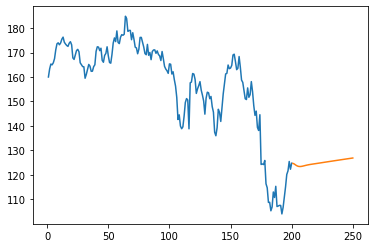

In [180]:
plt.plot(days_200,scaler.inverse_transform(dfc[1058:]))
plt.plot(days_pred,scaler.inverse_transform(lst_output))    

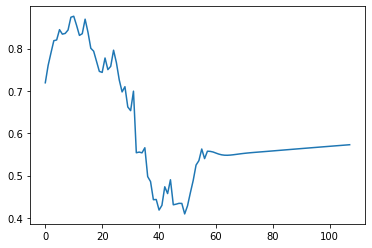

In [181]:
df2=dfc.tolist()
df2.extend(lst_output)
plt.plot(df2[1200:])

In [182]:
df2=scaler.inverse_transform(df2).tolist()

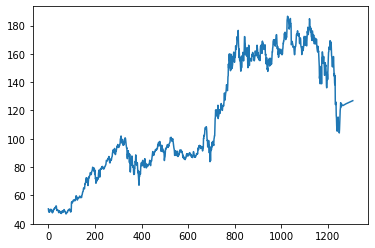

In [183]:
plt.plot(df2)